### t0-1_kobigbird-bert-base_bs_32_epoch_5_folds_10_lr_5e-05
- Kaggle notebook 사용

In [2]:
!nvidia-smi

Sun Dec 18 06:23:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

## Import

In [3]:
# !pip install -qqq colorama
# !pip install -qqq torchmetrics
# !pip install -qqq iterative-stratification

In [4]:
## Transformer 설치
# only in Colab
# !pip install -qqq --no-cache-dir transformers sentencepiece

In [5]:
import re
import os
import gc
import time
import random
import string

import copy
from copy import deepcopy

import torchmetrics

from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassF1Score

from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryAccuracy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from tqdm import tqdm

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Config

In [6]:
## Pytorch Import
import torch 
import torch.nn as nn

from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

## Transforemr Import
from transformers import AutoTokenizer, AutoModel, AdamW, AutoConfig, DataCollatorWithPadding

In [7]:
config ={
    'testnum' : 't0-1',
    #'dsinfo' : 'org_train',
    'model': 'monologg/kobigbird-bert-base', #"microsoft/deberta-v3-base",
    'learning_rate': 5e-5, 
    'seed': 2022,
    'n_folds' : 10,
    'n_epochs': 5,
    "train_batch_size": 32, #16, 
    "valid_batch_size": 32, #16, 
    "max_length": 128,
    "scheduler": 'CosineAnnealingLR', #'CosineAnnealingWarmRestarts', #'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "n_accumulate": 1,
    'target_cols': ['type', 'pn', 'time', 'sure'],
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

## 저장 폴더 생성

In [8]:
from datetime import datetime, timezone, timedelta
# 시간 고유값 
PROJECT_DIR = './'

os.chdir(PROJECT_DIR)
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")


# 기록 경로
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', train_serial + '_' + config['testnum'])
# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)  

print(RECORDER_DIR)

./results/20221218_152404_t0-1


In [9]:
data_path = '/kaggle/input/dacon-sentence-classification/'

model_save =  RECORDER_DIR +'/'
sub_path = RECORDER_DIR +'/'

model_save, sub_path

('./results/20221218_152404_t0-1/', './results/20221218_152404_t0-1/')

## Set Seed

In [10]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(config['seed'])

## Data

In [11]:
train = pd.read_csv(data_path + "train.csv")
test = pd.read_csv(data_path + "test.csv")
ss = pd.read_csv(data_path + "sample_submission.csv")

In [12]:
print("Train Shape: ", train.shape, "Test Shape: ", test.shape)
train.head()

Train Shape:  (16541, 7) Test Shape:  (7090, 2)


,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


In [13]:
train.문장.values[:3]

array(['0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.',
       '이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이라도 방역 지표가 기준을 충족하면 확진자 격리의무 조정 여부를 검토할 것＂이라고 전했다.',
       '정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지 확대한다.'],
      dtype=object)

## Column Rename

In [14]:
# train
train.rename(columns={'문장':'new_sentence'}, inplace = True)
train.head()

,ID,new_sentence,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


In [15]:
# test
test.rename(columns={'문장':'new_sentence'}, inplace = True)
test.head()

,ID,new_sentence
0,TEST_0000,"장욱진의 ＇가족＇은 허물 없는 가족애를, 처음 공개되는 정약용의 ＇정효자전＇과 ＇정..."
1,TEST_0001,"조지 W 부시, 버락 오바마 전 대통령도 전쟁 위험 때문에 버린 카드다."
2,TEST_0002,지난해 1분기 128억원이었던 영업이익이 올해 1분기 505억원으로 급증했다.
3,TEST_0003,수상 작가와 맺으려던 계약서 내용 가운데 일부가 ＇독소 조항＇으로 해석돼 수정을 요...
4,TEST_0004,결국 최근 KDB산업은행은 대규모 손실 위기에 닥친 에어부산에 140억원 금융지원을...


In [16]:
train.new_sentence.values[:3]

array(['0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.',
       '이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이라도 방역 지표가 기준을 충족하면 확진자 격리의무 조정 여부를 검토할 것＂이라고 전했다.',
       '정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지 확대한다.'],
      dtype=object)

In [17]:
train.columns

Index(['ID', 'new_sentence', '유형', '극성', '시제', '확실성', 'label'], dtype='object')

In [18]:
train.info() # 결측치는 없어보인다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16541 entries, 0 to 16540
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            16541 non-null  object
 1   new_sentence  16541 non-null  object
 2   유형            16541 non-null  object
 3   극성            16541 non-null  object
 4   시제            16541 non-null  object
 5   확실성           16541 non-null  object
 6   label         16541 non-null  object
dtypes: object(7)
memory usage: 904.7+ KB


## Target Categorical Encoding 

In [19]:
train.head()

,ID,new_sentence,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


In [20]:
train.columns[2:-1]

Index(['유형', '극성', '시제', '확실성'], dtype='object')

In [21]:
for target in train.columns[2:-2]:
    print(f"{target}: ", f"{train[target].unique()}")

유형:  ['사실형' '추론형' '예측형' '대화형']
극성:  ['긍정' '부정' '미정']
시제:  ['현재' '과거' '미래']


### 유형 -> type

In [22]:
# 유형 라벨 인코딩
print("유형")
target1_encode = {v: k for k, v in enumerate(train["유형"].unique())}
target1_encode

유형


{'사실형': 0, '추론형': 1, '예측형': 2, '대화형': 3}

In [23]:
target1_inverse = {v: k for k, v in target1_encode.items()}
target1_inverse

{0: '사실형', 1: '추론형', 2: '예측형', 3: '대화형'}

In [24]:
train['type'] = train["유형"].apply(lambda x: target1_encode[x])
train.head()

,ID,new_sentence,유형,극성,시제,확실성,label,type
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,0
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실,0
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실,0
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실,0
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,0


In [25]:
train["유형"].value_counts()

사실형    13558
추론형     2151
대화형      575
예측형      257
Name: 유형, dtype: int64

In [26]:
train["type"].value_counts()

0    13558
1     2151
3      575
2      257
Name: type, dtype: int64

### 극성 -> pn

In [27]:
# 유형 라벨 인코딩
print("극성")
target2_encode = {v: k for k, v in enumerate(train["극성"].unique())}
target2_encode

극성


{'긍정': 0, '부정': 1, '미정': 2}

In [28]:
target2_inverse = {v: k for k, v in target2_encode.items()}
target2_inverse

{0: '긍정', 1: '부정', 2: '미정'}

In [29]:
train['pn'] = train["극성"].apply(lambda x: target2_encode[x])
train.head()

,ID,new_sentence,유형,극성,시제,확실성,label,type,pn
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,0,0
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실,0,0
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실,0,0
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실,0,0
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,0,0


In [30]:
train["극성"].value_counts()

긍정    15793
부정      565
미정      183
Name: 극성, dtype: int64

In [31]:
train["pn"].value_counts()

0    15793
1      565
2      183
Name: pn, dtype: int64

### 시제 -> time

In [32]:
# 유형 라벨 인코딩
print("시제")
target3_encode = {v: k for k, v in enumerate(train["시제"].unique())}
target3_encode

시제


{'현재': 0, '과거': 1, '미래': 2}

In [33]:
target3_inverse = {v: k for k, v in target3_encode.items()}
target3_inverse

{0: '현재', 1: '과거', 2: '미래'}

In [34]:
train['time'] = train["시제"].apply(lambda x: target3_encode[x])
train.head()

,ID,new_sentence,유형,극성,시제,확실성,label,type,pn,time
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,0,0,0
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실,0,0,1
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실,0,0,2
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실,0,0,1
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,0,0,0


In [35]:
train["시제"].value_counts()

과거    8032
현재    6866
미래    1643
Name: 시제, dtype: int64

In [36]:
train["time"].value_counts()

1    8032
0    6866
2    1643
Name: time, dtype: int64

### 확실성 -> sure

In [37]:
# 유형 라벨 인코딩
print("확실성")
train['sure'] = train["확실성"].apply(lambda x: 1 if x == '확실' else 0)
train.head()

확실성


,ID,new_sentence,유형,극성,시제,확실성,label,type,pn,time,sure
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,0,0,0,1
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실,0,0,1,1
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실,0,0,2,1
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실,0,0,1,1
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,0,0,0,1


In [38]:
train["확실성"].value_counts()

확실     15192
불확실     1349
Name: 확실성, dtype: int64

In [39]:
train["sure"].value_counts()

1    15192
0     1349
Name: sure, dtype: int64

In [40]:
train.shape

(16541, 11)

In [48]:
train["label"].value_counts()

사실형-긍정-과거-확실     7113
사실형-긍정-현재-확실     4743
추론형-긍정-현재-확실     1101
사실형-긍정-미래-확실      649
추론형-긍정-과거-확실      335
                 ... 
대화형-미정-과거-확실        1
예측형-미정-현재-확실        1
예측형-부정-현재-불확실       1
예측형-부정-과거-확실        1
예측형-미정-과거-확실        1
Name: label, Length: 64, dtype: int64

In [52]:
train.columns

Index(['ID', 'new_sentence', '유형', '극성', '시제', '확실성', 'label', 'type', 'pn',
       'time', 'sure', 'label_72'],
      dtype='object')

In [53]:
train.drop(['ID', '유형', '극성', '시제', '확실성', 'label'], axis = 1, inplace = True)

In [54]:
print(train.shape)
train.head()

(16541, 6)


,new_sentence,type,pn,time,sure,label_72
0,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,0,0,0,1,23
1,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,0,0,1,1,19
2,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,0,0,2,1,21
3,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",0,0,1,1,19
4,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,0,0,0,1,23


## AutoTokenizer

In [55]:
config['tokenizer'] = AutoTokenizer.from_pretrained(config['model'])

Downloading:   0%|          | 0.00/373 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/169 [00:00<?, ?B/s]

### Max Length

In [56]:
max_len = 0
lens = []
for index in range(train.shape[0]):
    lens2 = len(config['tokenizer'].tokenize(train.loc[index, "new_sentence"]))
    lens.append(lens2)
    if lens2 > max_len:
        max_len = lens2

max_len

314

In [57]:
np.mean(lens)

33.517018318118616

<AxesSubplot:ylabel='Count'>

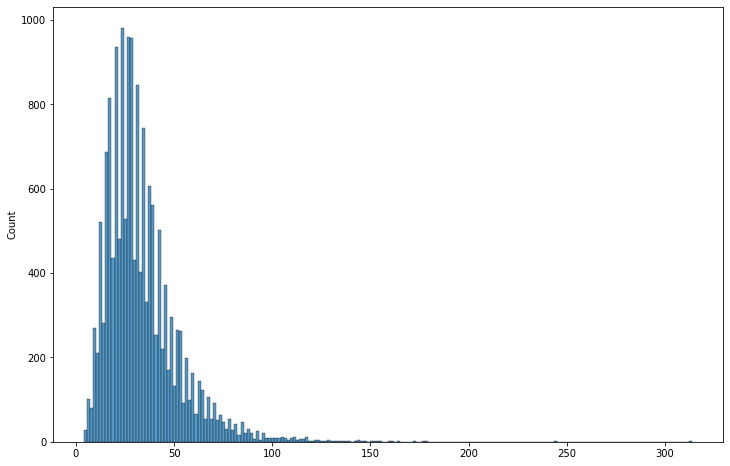

In [58]:
import seaborn as sns

plt.figure(figsize = (12, 8))
sns.histplot(data= lens)

In [59]:
a = dict()
k = 0
for index in range(len(lens)):
    if lens[index] >= 128:
        if lens[index] not in a.keys():
            a[lens[index]] = 1
        else:
            a[lens[index]] += 1 

In [60]:
a

{146: 3,
 128: 3,
 130: 1,
 173: 1,
 144: 4,
 244: 1,
 135: 1,
 138: 1,
 162: 1,
 152: 1,
 161: 1,
 142: 1,
 139: 1,
 136: 2,
 133: 1,
 314: 1,
 155: 1,
 140: 2,
 179: 1,
 177: 1,
 165: 1,
 129: 1,
 151: 1,
 132: 2,
 164: 1,
 148: 1,
 147: 1,
 159: 1,
 154: 1}

In [61]:
config['max_length']

128

## Dataset

In [62]:
train.columns

Index(['new_sentence', 'type', 'pn', 'time', 'sure', 'label_72'], dtype='object')

In [63]:
class MyDataset(Dataset):
    def __init__(self, 
                 df = train, 
                 tokenizer = config['tokenizer'], 
                 max_length = config['max_length'], 
                 mode = "train"):
        self.df = df
        self.max_length=  max_length
        self.tokenizer = tokenizer
        self.mode = mode

        # x
        self.text = self.df.new_sentence.values


        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        sentence = self.text[idx]

        inputs = self.tokenizer.encode_plus(sentence, 
                                            add_special_tokens=True,
                                            # padding='max_length', 
                                            max_length = self.max_length, 
                                            truncation=True)
        
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        if self.mode == "train":
            
            # y1: TYPE - 유형
            y_type = self.df['type'].values[idx]

            # y2:  PN - 극성
            y_pn = self.df['pn'].values[idx]

            # y3: time - 시제
            y_time = self.df['time'].values[idx]

            # y4: sure - 확실성
            y_sure = self.df['sure'].values[idx]


            return {'input_ids': inputs['input_ids'],
                    'attention_mask': inputs['attention_mask'],
                    'target_type': y_type,
                    'target_pn': y_pn,
                    'target_time': y_time,
                    'target_sure': y_sure}

        else:
            return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'],}

## Collate_fn

In [64]:
collate_fn = DataCollatorWithPadding(tokenizer=config['tokenizer'] )

##  MultilabelStratifiedKFold

In [65]:
train.head()

,new_sentence,type,pn,time,sure,label_72
0,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,0,0,0,1,23
1,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,0,0,1,1,19
2,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,0,0,2,1,21
3,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",0,0,1,1,19
4,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,0,0,0,1,23


In [66]:
train.columns

Index(['new_sentence', 'type', 'pn', 'time', 'sure', 'label_72'], dtype='object')

In [67]:
config['target_cols'] = ['type', 'pn', 'time', 'sure']
config['target_cols']

['type', 'pn', 'time', 'sure']

In [68]:
config['n_folds']

10

In [69]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

skf = MultilabelStratifiedKFold(n_splits = config['n_folds'], shuffle = True, random_state = config['seed'])

for fold, (_, val_index) in enumerate(skf.split(X=train, y=train[config['target_cols']])):
    train.loc[val_index, 'kfold'] = int(fold)

train['kfold'] = train['kfold'].astype('int')
print(train.shape)
train.head()

(16541, 7)


,new_sentence,type,pn,time,sure,label_72,kfold
0,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,0,0,0,1,23,6
1,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,0,0,1,1,19,0
2,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,0,0,2,1,21,2
3,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",0,0,1,1,19,9
4,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,0,0,0,1,23,2


## Dataset -> DataLoader in ONESHOT

In [70]:
def prepare_loader(fold):
    
    train_df = train[train.kfold != fold].reset_index(drop=True)
    valid_df = train[train.kfold == fold].reset_index(drop=True)

    ## train, valid -> Dataset
    train_ds = MyDataset(train_df, 
                       tokenizer = config['tokenizer'],
                       max_length = config['max_length'],
                       mode = "train")

    valid_ds = MyDataset(valid_df, 
                       tokenizer = config['tokenizer'],
                       max_length = config['max_length'],
                       mode = "train")
    
    # Dataset -> DataLoader
    train_loader = DataLoader(train_ds,
                              batch_size = config['train_batch_size'], 
                              collate_fn=collate_fn, 
                              num_workers = 2,
                              shuffle = True, 
                              pin_memory = True, 
                              drop_last= True)

    valid_loader = DataLoader(valid_ds,
                              batch_size = config['valid_batch_size'],
                              collate_fn=collate_fn,
                              num_workers = 2,
                              shuffle = False, 
                              pin_memory = True,)
    
    return train_loader, valid_loader

## MODEL

In [71]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [72]:
class Model(nn.Module):
    def __init__(self, model_name):
        super(Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name,  attention_type="original_full")
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()

        # TYPE: 유형
        self.fc_type = nn.Linear(self.config.hidden_size, 4)
        self.logsoftmax_type = nn.LogSoftmax(dim = -1)

        # PN: 극성
        self.fc_pn = nn.Linear(self.config.hidden_size, 3)
        self.logsoftmax_pn = nn.LogSoftmax(dim = -1)

        # TIME: 시제
        self.fc_time = nn.Linear(self.config.hidden_size, 3)
        self.logsoftmax_time = nn.LogSoftmax(dim = -1)

        # SURE: 확실성 - Binary Classification
        self.fc_sure = nn.Linear(self.config.hidden_size, 1)
        self.sigmoid_sure = nn.Sigmoid()
        

    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)

        # TYPE: 유형
        out_type = self.fc_type(out)
        out_type = self.logsoftmax_type(out_type)

        # PN: 극성
        out_pn = self.fc_pn(out)
        out_pn = self.logsoftmax_pn(out_pn)

        # TIME: 시제
        out_time = self.fc_time(out)
        out_time = self.logsoftmax_time(out_time)

        # SURE: 확실성 - Binary Classification
        out_sure = self.fc_sure(out)
        out_sure = self.sigmoid_sure(out_sure)
        
        outputs = {'type': out_type, 'pn': out_pn, 'time': out_time, 'sure': out_sure}

        return outputs

In [73]:
model = Model(config['model'])
model = model.to(config['device'])

Downloading:   0%|          | 0.00/870 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Loss Function

In [74]:
loss_fn = {'type': nn.NLLLoss().to(config['device']),
           'pn' : nn.NLLLoss().to(config['device']),
           'time': nn.NLLLoss().to(config['device']),
           'sure': nn.BCELoss().to(config['device'])}

## Optimizer & Scheduler

In [75]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['learning_rate'], 
                              weight_decay=config['weight_decay']
                              )

In [77]:
import torch.optim as optim

class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

## torchmetrics - Metric Func

In [79]:
# What I Tired to do ...
acc_type, f1_type = 0.784, 0.784
acc_pn, f1_pn = 0.223, 0.784
acc_sure, f1_sure = 0.222, 0.334
acc_time, f1_time =0.222, 0.332

print(f"Train | Type' | PosNg | Time' | Sure' |")
print(f"ACCUR | {acc_type:.3f} | {acc_pn:.3f} | {acc_time:.3f} | {acc_sure:.3f} |")
print(f"F1_SC | {f1_type:.3f} | {f1_pn:.3f} | {f1_time:.3f} | {f1_sure:.3f} |")

Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.784 | 0.223 | 0.222 | 0.222 |
F1_SC | 0.784 | 0.784 | 0.332 | 0.334 |


## Train One Epoch Function

In [80]:
def train_one_epoch(model, 
                    dataloader, 
                    optimizer,
                    scheduler,
                    epoch,
                    device = config['device']):


    ################ torchmetrics: initialize metric #########################
    metric_acc_type = MulticlassAccuracy(average = 'weighted', num_classes = 4).to(config['device'])
    metric_f1_type = MulticlassF1Score(average = 'weighted', num_classes=4).to(config['device'])

    metric_acc_pn = MulticlassAccuracy(average = 'weighted', num_classes = 3).to(config['device'])
    metric_f1_pn = MulticlassF1Score(average = 'weighted', num_classes = 3).to(config['device'])

    metric_acc_time = MulticlassAccuracy(average = 'weighted', num_classes = 3).to(config['device'])
    metric_f1_time = MulticlassF1Score(average = 'weighted', num_classes=3).to(config['device'])

    metric_bi_acc = BinaryAccuracy().to(config['device'])
    metric_bi_f1 = BinaryF1Score().to(config['device'])
    
    ############################################################################

    train_loss = 0
    dataset_size = 0

    bar = tqdm(enumerate(dataloader), total = len(dataloader))

    model.train()
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        masks = data['attention_mask'].to(device, dtype = torch.long)
        # targets
        t_type = data['target_type'].to(device, dtype = torch.long)
        t_pn = data['target_pn'].to(device, dtype = torch.long)
        t_time = data['target_time'].to(device, dtype = torch.long)
        t_sure = data['target_sure'].to(device, dtype = torch.float)
 
        # y_preds
        y_preds = model(ids, masks) 

        # Loss
        loss1 = loss_fn['type'](y_preds['type'], t_type )
        loss2 = loss_fn['pn'](y_preds['pn'], t_pn )
        loss3 = loss_fn['time'](y_preds['time'], t_time )
        y_preds['sure'] = y_preds['sure'].view(-1)
        loss4 = loss_fn['sure'](y_preds['sure'], t_sure )

        # loss sum
        loss = (loss1 + loss2 + loss3 + loss4) / 4

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient-Clipping | source: https://velog.io/@seven7724/Transformer-계열의-훈련-Tricks
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        optimizer.step()

        if scheduler is not None:
            scheduler.step()
        
        batch_size = ids.size(0)
        dataset_size += batch_size
        train_loss += float(loss.item() * batch_size) 
        train_epoch_loss = train_loss / dataset_size 
        
        # Type - ACC, F1
        acc_type = metric_acc_type(y_preds['type'], t_type )
        acc_type = acc_type.detach().cpu().item()
        f1_type = metric_f1_type(y_preds['type'], t_type )
        f1_type = f1_type.detach().cpu().item()

        # PN - ACC, F1
        acc_pn = metric_acc_pn(y_preds['pn'], t_pn )
        acc_pn = acc_pn.detach().cpu().item()
        f1_pn = metric_f1_pn(y_preds['pn'], t_pn )
        f1_pn = f1_pn.detach().cpu().item()

        # TIME - ACC, F1
        acc_time = metric_acc_time(y_preds['time'], t_time )
        acc_time = acc_time.detach().cpu().item()
        f1_time = metric_f1_time(y_preds['time'], t_time )
        f1_time = f1_time.detach().cpu().item()

        # SURE - ACC, F1
        acc_sure = metric_bi_acc(y_preds['sure'], t_sure )
        acc_sure = acc_sure.detach().cpu().item()
        f1_sure = metric_bi_f1(y_preds['sure'], t_sure )
        f1_sure = f1_sure.detach().cpu().item()

        bar.set_postfix(Epoch = epoch, 
                        Train_loss = train_epoch_loss,
                        LR = optimizer.param_groups[0]['lr'])
        
    # Type - ACC, F1
    acc_type = metric_acc_type.compute()
    f1_type = metric_f1_type.compute()

    # PN - ACC, F1
    acc_pn = metric_acc_pn.compute()
    f1_pn = metric_f1_pn.compute()

    # TIME - ACC, F1
    acc_time = metric_acc_time.compute()
    f1_time = metric_f1_time.compute()

    # SURE - ACC, F1
    acc_sure = metric_bi_acc.compute()
    f1_sure = metric_bi_f1.compute()


    print(f"Train | Type' | PosNg | Time' | Sure' |")
    print(f"ACCUR | {acc_type:.3f} | {acc_pn:.3f} | {acc_time:.3f} | {acc_sure:.3f} |")
    print(f"F1_SC | {f1_type:.3f} | {f1_pn:.3f} | {f1_time:.3f} | {f1_sure:.3f} |")

    print()

    acc_metric = {'type': acc_type, 'pn' : acc_pn,'time': acc_time,'sure': acc_sure}
    f1_metric = {'type': f1_type, 'pn' : f1_pn,'time': f1_time,'sure': f1_sure}

    del acc_type, acc_pn, acc_time, acc_sure, f1_type, f1_pn, f1_time, f1_sure
 
    metric_acc_type.reset()
    metric_acc_pn.reset()
    metric_acc_time.reset()
    metric_bi_acc.reset()

    metric_bi_acc.reset()
    metric_f1_pn.reset()
    metric_f1_time.reset()
    metric_bi_f1.reset()

    torch.cuda.empty_cache()
    _ = gc.collect()

    return train_epoch_loss, acc_metric, f1_metric

## Valid One Epoch Function

In [81]:
## Annotation
@torch.no_grad()
def valid_one_epoch(model, 
                    dataloader, 
                    epoch, 
                    device = config['device']):
    

    ################ torchmetrics: initialize metric #########################
    metric_acc_type = MulticlassAccuracy(average = 'weighted', num_classes = 4).to(config['device'])
    metric_f1_type = MulticlassF1Score(average = 'weighted', num_classes=4).to(config['device'])

    metric_acc_pn = MulticlassAccuracy(average = 'weighted', num_classes = 3).to(config['device'])
    metric_f1_pn = MulticlassF1Score(average = 'weighted', num_classes = 3).to(config['device'])

    metric_acc_time = MulticlassAccuracy(average = 'weighted', num_classes = 3).to(config['device'])
    metric_f1_time = MulticlassF1Score(average = 'weighted', num_classes=3).to(config['device'])

    metric_bi_acc = BinaryAccuracy().to(config['device'])
    metric_bi_f1 = BinaryF1Score().to(config['device'])
    
    ############################################################################
    
    valid_loss = 0
    dataset_size = 0
     
    bar = tqdm(enumerate(dataloader), total = len(dataloader))

    model.eval()
    with torch.no_grad():
        for step, data in bar:
            ids = data['input_ids'].to(device, dtype = torch.long)
            masks = data['attention_mask'].to(device, dtype = torch.long)

            # targets
            t_type = data['target_type'].to(device, dtype = torch.long)
            t_pn = data['target_pn'].to(device, dtype = torch.long)
            t_time = data['target_time'].to(device, dtype = torch.long)
            t_sure = data['target_sure'].to(device, dtype = torch.float)
    
            # y_preds
            y_preds = model(ids, masks) 

            # Loss
            loss1 = loss_fn['type'](y_preds['type'], t_type )
            loss2 = loss_fn['pn'](y_preds['pn'], t_pn )
            loss3 = loss_fn['time'](y_preds['time'], t_time )
            y_preds['sure'] = y_preds['sure'].view(-1)
            loss4 = loss_fn['sure'](y_preds['sure'], t_sure )

            # loss sum
            loss = (loss1 + loss2 + loss3 + loss4) / 4

            # 실시간 Loss
            batch_size = ids.size(0)
            dataset_size += batch_size
            valid_loss += float(loss.item() * batch_size)
            valid_epoch_loss = valid_loss / dataset_size

            # Type - ACC, F1
            acc_type = metric_acc_type(y_preds['type'], t_type )
            acc_type = acc_type.detach().cpu().item()
            f1_type = metric_f1_type(y_preds['type'], t_type )
            f1_type = f1_type.detach().cpu().item()

            # PN - ACC, F1
            acc_pn = metric_acc_pn(y_preds['pn'], t_pn )
            acc_pn = acc_pn.detach().cpu().item()
            f1_pn = metric_f1_pn(y_preds['pn'], t_pn )
            f1_pn = f1_pn.detach().cpu().item()

            # TIME - ACC, F1
            acc_time = metric_acc_time(y_preds['time'], t_time )
            acc_time = acc_time.detach().cpu().item()
            f1_time = metric_f1_time(y_preds['time'], t_time )
            f1_time = f1_time.detach().cpu().item()

            # SURE - ACC, F1
            acc_sure = metric_bi_acc(y_preds['sure'], t_sure )
            acc_sure = acc_sure.detach().cpu().item()
            f1_sure = metric_bi_f1(y_preds['sure'], t_sure )
            f1_sure = f1_sure.detach().cpu().item()

            bar.set_postfix(Epoch = epoch, 
                            Valid_loss = valid_epoch_loss,
                            LR = optimizer.param_groups[0]['lr'],
                            )

    # Type - ACC, F1
    acc_type = metric_acc_type.compute()
    f1_type = metric_f1_type.compute()

    # PN - ACC, F1
    acc_pn = metric_acc_pn.compute()
    f1_pn = metric_f1_pn.compute()

    # TIME - ACC, F1
    acc_time = metric_acc_time.compute()
    f1_time = metric_f1_time.compute()

    # SURE - ACC, F1
    acc_sure = metric_bi_acc.compute()
    f1_sure = metric_bi_f1.compute()


    print(f"Valid | Type' | PosNg | Time' | Sure' |")
    print(f"ACCUR | {acc_type:.3f} | {acc_pn:.3f} | {acc_time:.3f} | {acc_sure:.3f} |")
    print(f"F1_SC | {f1_type:.3f} | {f1_pn:.3f} | {f1_time:.3f} | {f1_sure:.3f} |")
    print()

    acc_metric = {'type': acc_type, 'pn' : acc_pn,'time': acc_time,'sure': acc_sure}
    f1_metric = {'type': f1_type, 'pn' : f1_pn,'time': f1_time,'sure': f1_sure}

    del acc_type, acc_pn, acc_time, acc_sure, f1_type, f1_pn, f1_time, f1_sure
    
    metric_acc_type.reset()
    metric_acc_pn.reset()
    metric_acc_time.reset()
    metric_bi_acc.reset()

    metric_bi_acc.reset()
    metric_f1_pn.reset()
    metric_f1_time.reset()
    metric_bi_f1.reset()

    torch.cuda.empty_cache()
    _ = gc.collect()

    return valid_epoch_loss, acc_metric, f1_metric

## Run Training Function

In [83]:
model_save

'./results/20221218_152404_t0-1/'

In [84]:
sub_path

'./results/20221218_152404_t0-1/'

In [85]:
# # How to get Avg F1 Score
f1_metric_sample = {'type': 98.223, 'pn' : 82.334, 'time': 88.1, 'sure': 99.1111}
sum(f1_metric_sample.values()) / len(f1_metric_sample.values())

91.942025

In [86]:
def run_training(model, optimizer, scheduler, device, n_epochs, fold):

    if torch.cuda.is_available():
        print("INFO: GPU - {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()

    lowest_epoch = np.inf
    lowest_loss = np.inf

    
    best_score = 0
    best_score_epoch = np.inf
    best_model = "None"

    for epoch in range(1, n_epochs +1):
        gc.collect()

        train_epoch_loss, train_acc_metric, train_f1_metric = train_one_epoch(model= model, dataloader = train_loader, optimizer = optimizer,
                                                                              scheduler = scheduler, device = config['device'], epoch = epoch)
                                                                                
        
        valid_epoch_loss, valid_acc_metric, valid_f1_metric = valid_one_epoch(model, dataloader = valid_loader,
                                                                              device = config['device'], epoch = epoch)
        # Mean Weighted F1_score
        train_f1 = sum(train_f1_metric.values()) / len(train_f1_metric.values())
        valid_f1 = sum(valid_f1_metric.values()) / len(valid_f1_metric.values())
        
        print()
        print(f"Epoch:{epoch:02d} | TL:{train_epoch_loss:.3e} | VL:{valid_epoch_loss:.3e} | Train's F1: {train_f1:.3f} | Valid's F1: {valid_f1:.3f} | ")
        print()

        if valid_epoch_loss < lowest_loss:
            print(f"{b_}Validation Loss Improved({lowest_loss:.3e}) --> ({valid_epoch_loss:.3e})")
            lowest_loss = valid_epoch_loss
            lowest_epoch = epoch
            PATH = model_save + f"Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Better Loss Model Saved{sr_}")

        if best_score < valid_f1:
            print(f"{b_}F1 Improved({best_score:.3f}) --> ({valid_f1:.3f})")
            best_score = valid_f1
            best_score_epoch = epoch
            PATH2 = model_save + f"Loss-Fold-{fold}_f1.bin"
            torch.save(model.state_dict(), PATH2)
            print(f"Better_F1_Model Saved{sr_}")
    
        
        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss : %.4e at %d th Epoch of %dth Fold" % (lowest_loss, lowest_epoch, fold))
    print("Best F1(W): %.4f at %d th Epoch of %dth Fold" % (best_score, best_score_epoch, fold))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    
    return model, best_score

## Train Start

In [87]:
config['n_folds'], config['n_epochs']

(10, 5)

In [88]:
config['train_batch_size'], config['valid_batch_size']

(32, 32)

In [89]:
# import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [90]:
best_scores = []

for fold in range(0, config['n_folds']):

    print(f"{y_}==== Fold: {fold} ====={sr_}")

    # DataLoaders
    train_loader, valid_loader = prepare_loader(fold = fold)

    # Define Model because of KFold
    model = Model(config['model'])
    model = model.to(config['device'])

    # Loss Function
    loss_fn = {'type': nn.NLLLoss().to(config['device']),
                'pn' : nn.NLLLoss().to(config['device']),
                'time': nn.NLLLoss().to(config['device']),
                'sure': nn.BCELoss().to(config['device'])}

    # Define Opimizer and Scheduler
    optimizer = AdamW(model.parameters(),
                      lr = config['learning_rate'],
                      weight_decay = config['weight_decay'])
    
    scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)
    # scheduler = fetch_scheduler(optimizer)

    ## Start Training
    model, best_score = run_training(model, optimizer, scheduler, device = config['device'], n_epochs = config['n_epochs'], fold = fold)
    
    ## Best F1_Score per Fold 줍줍
    best_scores.append(best_score)
    
    ## For Memory
    del model, train_loader, valid_loader

    torch.cuda.empty_cache()
    _ = gc.collect()
    
    print()

==== Fold: 0 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.60it/s, Epoch=1, LR=4.36e-5, Train_loss=0.307]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.862 | 0.965 | 0.833 | 0.921 |
F1_SC | 0.843 | 0.958 | 0.828 | 0.958 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  5.19it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.198]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.84it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.198]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.906 | 0.972 | 0.899 | 0.938 |
F1_SC | 0.895 | 0.972 | 0.895 | 0.967 |


Epoch:01 | TL:3.074e-01 | VL:1.976e-01 | Train's F1: 0.897 | Valid's F1: 0.932 | 

Validation Loss Improved(inf) --> (1.976e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.932)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.58it/s, Epoch=2, LR=2.77e-5, Train_loss=0.185]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.905 | 0.976 | 0.915 | 0.936 |
F1_SC | 0.901 | 0.974 | 0.914 | 0.966 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  5.18it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.193]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.90it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.193]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.901 | 0.978 | 0.897 | 0.932 |
F1_SC | 0.897 | 0.974 | 0.896 | 0.963 |


Epoch:02 | TL:1.851e-01 | VL:1.928e-01 | Train's F1: 0.939 | Valid's F1: 0.933 | 

Validation Loss Improved(1.976e-01) --> (1.928e-01)
Better Loss Model Saved
F1 Improved(0.932) --> (0.933)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=3, LR=1.05e-5, Train_loss=0.141]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.934 | 0.983 | 0.939 | 0.945 |
F1_SC | 0.932 | 0.981 | 0.939 | 0.970 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  5.14it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.198]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.88it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.198]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.896 | 0.976 | 0.901 | 0.935 |
F1_SC | 0.894 | 0.975 | 0.900 | 0.965 |


Epoch:03 | TL:1.412e-01 | VL:1.975e-01 | Train's F1: 0.955 | Valid's F1: 0.934 | 

F1 Improved(0.933) --> (0.934)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.75it/s, Epoch=4, LR=6.02e-7, Train_loss=0.106]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=4, LR=6.02e-7, Train_loss=0.106]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.958 | 0.986 | 0.959 | 0.954 |
F1_SC | 0.958 | 0.985 | 0.959 | 0.975 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.81it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.213]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.891 | 0.978 | 0.899 | 0.937 |
F1_SC | 0.891 | 0.977 | 0.898 | 0.966 |


Epoch:04 | TL:1.064e-01 | VL:2.130e-01 | Train's F1: 0.969 | Valid's F1: 0.933 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.41it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0959]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0959]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.966 | 0.988 | 0.965 | 0.956 |
F1_SC | 0.966 | 0.987 | 0.965 | 0.976 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.94it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.215]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.892 | 0.976 | 0.899 | 0.933 |
F1_SC | 0.891 | 0.975 | 0.898 | 0.964 |


Epoch:05 | TL:9.593e-02 | VL:2.150e-01 | Train's F1: 0.973 | Valid's F1: 0.932 | 


Training complete in 0h 25m 26s
Best Loss : 1.9277e-01 at 2 th Epoch of 0th Fold
Best F1(W): 0.9335 at 3 th Epoch of 0th Fold

==== Fold: 1 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:48<00:00,  1.61it/s, Epoch=1, LR=4.36e-5, Train_loss=0.325]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.858 | 0.929 | 0.822 | 0.926 |
F1_SC | 0.839 | 0.938 | 0.816 | 0.961 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.96it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.203]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.70it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.203]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.898 | 0.975 | 0.913 | 0.933 |
F1_SC | 0.885 | 0.972 | 0.911 | 0.965 |


Epoch:01 | TL:3.252e-01 | VL:2.028e-01 | Train's F1: 0.888 | Valid's F1: 0.933 | 

Validation Loss Improved(inf) --> (2.028e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.933)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:49<00:00,  1.61it/s, Epoch=2, LR=2.77e-5, Train_loss=0.188]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.906 | 0.977 | 0.914 | 0.937 |
F1_SC | 0.900 | 0.974 | 0.913 | 0.966 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.79it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.191]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.899 | 0.978 | 0.910 | 0.930 |
F1_SC | 0.891 | 0.975 | 0.910 | 0.962 |


Epoch:02 | TL:1.878e-01 | VL:1.913e-01 | Train's F1: 0.938 | Valid's F1: 0.934 | 

Validation Loss Improved(2.028e-01) --> (1.913e-01)
Better Loss Model Saved
F1 Improved(0.933) --> (0.934)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=3, LR=1.05e-5, Train_loss=0.145]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.931 | 0.982 | 0.937 | 0.947 |
F1_SC | 0.929 | 0.980 | 0.937 | 0.971 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.76it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.191]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.903 | 0.980 | 0.912 | 0.934 |
F1_SC | 0.901 | 0.978 | 0.912 | 0.964 |


Epoch:03 | TL:1.447e-01 | VL:1.912e-01 | Train's F1: 0.954 | Valid's F1: 0.939 | 

Validation Loss Improved(1.913e-01) --> (1.912e-01)
Better Loss Model Saved
F1 Improved(0.934) --> (0.939)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=4, LR=6.02e-7, Train_loss=0.109]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.959 | 0.987 | 0.957 | 0.956 |
F1_SC | 0.958 | 0.985 | 0.957 | 0.976 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.98it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.201]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.72it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.201]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.900 | 0.980 | 0.915 | 0.932 |
F1_SC | 0.898 | 0.978 | 0.916 | 0.963 |


Epoch:04 | TL:1.087e-01 | VL:2.008e-01 | Train's F1: 0.969 | Valid's F1: 0.939 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.59it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0983]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.967 | 0.988 | 0.965 | 0.957 |
F1_SC | 0.967 | 0.986 | 0.965 | 0.977 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.97it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.203]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.82it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.203]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.901 | 0.980 | 0.915 | 0.933 |
F1_SC | 0.899 | 0.978 | 0.915 | 0.964 |


Epoch:05 | TL:9.827e-02 | VL:2.031e-01 | Train's F1: 0.974 | Valid's F1: 0.939 | 

F1 Improved(0.939) --> (0.939)
Better_F1_Model Saved

Training complete in 0h 25m 17s
Best Loss : 1.9123e-01 at 3 th Epoch of 1th Fold
Best F1(W): 0.9391 at 5 th Epoch of 1th Fold

==== Fold: 2 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.51it/s, Epoch=1, LR=4.36e-5, Train_loss=0.346]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=1, LR=4.36e-5, Train_loss=0.346]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.830 | 0.937 | 0.800 | 0.898 |
F1_SC | 0.818 | 0.936 | 0.795 | 0.945 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.71it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.23]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.889 | 0.973 | 0.882 | 0.936 |
F1_SC | 0.880 | 0.968 | 0.884 | 0.965 |


Epoch:01 | TL:3.458e-01 | VL:2.302e-01 | Train's F1: 0.873 | Valid's F1: 0.924 | 

Validation Loss Improved(inf) --> (2.302e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.924)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=2, LR=2.77e-5, Train_loss=0.188]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.903 | 0.976 | 0.916 | 0.935 |
F1_SC | 0.898 | 0.973 | 0.915 | 0.965 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.44it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.213]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.892 | 0.975 | 0.887 | 0.942 |
F1_SC | 0.889 | 0.973 | 0.890 | 0.969 |


Epoch:02 | TL:1.879e-01 | VL:2.129e-01 | Train's F1: 0.938 | Valid's F1: 0.930 | 

Validation Loss Improved(2.302e-01) --> (2.129e-01)
Better Loss Model Saved
F1 Improved(0.924) --> (0.930)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=3, LR=1.05e-5, Train_loss=0.144]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.932 | 0.982 | 0.936 | 0.943 |
F1_SC | 0.930 | 0.980 | 0.936 | 0.969 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.69it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.213]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.899 | 0.973 | 0.891 | 0.941 |
F1_SC | 0.897 | 0.971 | 0.891 | 0.968 |


Epoch:03 | TL:1.436e-01 | VL:2.130e-01 | Train's F1: 0.954 | Valid's F1: 0.932 | 

F1 Improved(0.930) --> (0.932)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=4, LR=6.02e-7, Train_loss=0.108]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.961 | 0.987 | 0.959 | 0.952 |
F1_SC | 0.960 | 0.985 | 0.959 | 0.974 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.70it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.225]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.891 | 0.973 | 0.893 | 0.941 |
F1_SC | 0.888 | 0.971 | 0.894 | 0.968 |


Epoch:04 | TL:1.081e-01 | VL:2.252e-01 | Train's F1: 0.970 | Valid's F1: 0.930 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.60it/s, Epoch=5, LR=3.19e-6, Train_loss=0.097]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.969 | 0.988 | 0.964 | 0.955 |
F1_SC | 0.968 | 0.986 | 0.964 | 0.976 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.64it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.229]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.890 | 0.973 | 0.892 | 0.942 |
F1_SC | 0.890 | 0.971 | 0.892 | 0.969 |


Epoch:05 | TL:9.695e-02 | VL:2.288e-01 | Train's F1: 0.973 | Valid's F1: 0.930 | 


Training complete in 0h 25m 28s
Best Loss : 2.1294e-01 at 2 th Epoch of 2th Fold
Best F1(W): 0.9318 at 3 th Epoch of 2th Fold

==== Fold: 3 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:49<00:00,  1.61it/s, Epoch=1, LR=4.36e-5, Train_loss=0.328]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.837 | 0.944 | 0.824 | 0.909 |
F1_SC | 0.826 | 0.942 | 0.818 | 0.951 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.61it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.22]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.897 | 0.972 | 0.895 | 0.932 |
F1_SC | 0.879 | 0.967 | 0.888 | 0.964 |


Epoch:01 | TL:3.276e-01 | VL:2.200e-01 | Train's F1: 0.884 | Valid's F1: 0.924 | 

Validation Loss Improved(inf) --> (2.200e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.924)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=2, LR=2.77e-5, Train_loss=0.188]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.906 | 0.977 | 0.913 | 0.937 |
F1_SC | 0.900 | 0.974 | 0.912 | 0.966 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.55it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.205]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.897 | 0.973 | 0.905 | 0.918 |
F1_SC | 0.896 | 0.971 | 0.905 | 0.955 |


Epoch:02 | TL:1.883e-01 | VL:2.050e-01 | Train's F1: 0.938 | Valid's F1: 0.932 | 

Validation Loss Improved(2.200e-01) --> (2.050e-01)
Better Loss Model Saved
F1 Improved(0.924) --> (0.932)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.79it/s, Epoch=3, LR=1.05e-5, Train_loss=0.143]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=3, LR=1.05e-5, Train_loss=0.143]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.932 | 0.983 | 0.937 | 0.945 |
F1_SC | 0.930 | 0.982 | 0.937 | 0.971 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.56it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.205]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.906 | 0.974 | 0.912 | 0.927 |
F1_SC | 0.902 | 0.970 | 0.911 | 0.961 |


Epoch:03 | TL:1.433e-01 | VL:2.051e-01 | Train's F1: 0.955 | Valid's F1: 0.936 | 

F1 Improved(0.932) --> (0.936)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.59it/s, Epoch=4, LR=6.02e-7, Train_loss=0.109]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.957 | 0.986 | 0.957 | 0.952 |
F1_SC | 0.956 | 0.985 | 0.957 | 0.974 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.45it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.217]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.905 | 0.974 | 0.909 | 0.919 |
F1_SC | 0.903 | 0.972 | 0.908 | 0.956 |


Epoch:04 | TL:1.091e-01 | VL:2.171e-01 | Train's F1: 0.968 | Valid's F1: 0.935 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.56it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0985]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0985]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.965 | 0.989 | 0.964 | 0.955 |
F1_SC | 0.964 | 0.987 | 0.964 | 0.976 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.59it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.221]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.907 | 0.972 | 0.911 | 0.922 |
F1_SC | 0.904 | 0.970 | 0.909 | 0.958 |


Epoch:05 | TL:9.848e-02 | VL:2.210e-01 | Train's F1: 0.973 | Valid's F1: 0.935 | 


Training complete in 0h 25m 20s
Best Loss : 2.0502e-01 at 2 th Epoch of 3th Fold
Best F1(W): 0.9359 at 3 th Epoch of 3th Fold

==== Fold: 4 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.59it/s, Epoch=1, LR=4.36e-5, Train_loss=0.321]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.862 | 0.956 | 0.825 | 0.900 |
F1_SC | 0.843 | 0.952 | 0.819 | 0.946 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:12<00:00,  4.31it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.217]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.889 | 0.980 | 0.896 | 0.937 |
F1_SC | 0.866 | 0.978 | 0.896 | 0.966 |


Epoch:01 | TL:3.207e-01 | VL:2.166e-01 | Train's F1: 0.890 | Valid's F1: 0.927 | 

Validation Loss Improved(inf) --> (2.166e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.927)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=2, LR=2.77e-5, Train_loss=0.188]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.906 | 0.975 | 0.912 | 0.936 |
F1_SC | 0.900 | 0.972 | 0.911 | 0.966 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  5.25it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.202]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.59it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.202]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.894 | 0.980 | 0.901 | 0.927 |
F1_SC | 0.894 | 0.976 | 0.903 | 0.960 |


Epoch:02 | TL:1.880e-01 | VL:2.021e-01 | Train's F1: 0.937 | Valid's F1: 0.933 | 

Validation Loss Improved(2.166e-01) --> (2.021e-01)
Better Loss Model Saved
F1 Improved(0.927) --> (0.933)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.59it/s, Epoch=3, LR=1.05e-5, Train_loss=0.146]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.60it/s, Epoch=3, LR=1.05e-5, Train_loss=0.146]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.931 | 0.982 | 0.938 | 0.944 |
F1_SC | 0.929 | 0.980 | 0.938 | 0.970 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  5.03it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.196]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.47it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.196]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.902 | 0.984 | 0.897 | 0.936 |
F1_SC | 0.897 | 0.983 | 0.897 | 0.966 |


Epoch:03 | TL:1.459e-01 | VL:1.957e-01 | Train's F1: 0.954 | Valid's F1: 0.936 | 

Validation Loss Improved(2.021e-01) --> (1.957e-01)
Better Loss Model Saved
F1 Improved(0.933) --> (0.936)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:54<00:00,  1.58it/s, Epoch=4, LR=6.02e-7, Train_loss=0.111]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.959 | 0.986 | 0.955 | 0.952 |
F1_SC | 0.958 | 0.984 | 0.955 | 0.974 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.52it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.205]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.903 | 0.982 | 0.898 | 0.938 |
F1_SC | 0.901 | 0.981 | 0.898 | 0.967 |


Epoch:04 | TL:1.105e-01 | VL:2.049e-01 | Train's F1: 0.968 | Valid's F1: 0.937 | 

F1 Improved(0.936) --> (0.937)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0995]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.966 | 0.988 | 0.964 | 0.955 |
F1_SC | 0.965 | 0.986 | 0.964 | 0.976 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.89it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.208]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.50it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.208]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.903 | 0.982 | 0.902 | 0.935 |
F1_SC | 0.902 | 0.981 | 0.902 | 0.965 |


Epoch:05 | TL:9.949e-02 | VL:2.082e-01 | Train's F1: 0.973 | Valid's F1: 0.937 | 

F1 Improved(0.937) --> (0.937)
Better_F1_Model Saved

Training complete in 0h 25m 34s
Best Loss : 1.9569e-01 at 3 th Epoch of 4th Fold
Best F1(W): 0.9374 at 5 th Epoch of 4th Fold

==== Fold: 5 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.58it/s, Epoch=1, LR=4.36e-5, Train_loss=0.334]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.831 | 0.961 | 0.807 | 0.901 |
F1_SC | 0.816 | 0.952 | 0.807 | 0.947 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.68it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.209]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.899 | 0.970 | 0.904 | 0.929 |
F1_SC | 0.895 | 0.966 | 0.902 | 0.962 |


Epoch:01 | TL:3.343e-01 | VL:2.089e-01 | Train's F1: 0.880 | Valid's F1: 0.931 | 

Validation Loss Improved(inf) --> (2.089e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.931)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=2, LR=2.77e-5, Train_loss=0.188]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.902 | 0.977 | 0.914 | 0.937 |
F1_SC | 0.897 | 0.974 | 0.913 | 0.966 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.80it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.201]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.902 | 0.973 | 0.903 | 0.929 |
F1_SC | 0.896 | 0.972 | 0.903 | 0.962 |


Epoch:02 | TL:1.884e-01 | VL:2.009e-01 | Train's F1: 0.937 | Valid's F1: 0.933 | 

Validation Loss Improved(2.089e-01) --> (2.009e-01)
Better Loss Model Saved
F1 Improved(0.931) --> (0.933)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.58it/s, Epoch=3, LR=1.05e-5, Train_loss=0.145]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.932 | 0.983 | 0.936 | 0.945 |
F1_SC | 0.930 | 0.981 | 0.936 | 0.970 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  5.17it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.199]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.80it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.199]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.900 | 0.978 | 0.908 | 0.930 |
F1_SC | 0.900 | 0.977 | 0.908 | 0.962 |


Epoch:03 | TL:1.449e-01 | VL:1.989e-01 | Train's F1: 0.954 | Valid's F1: 0.937 | 

Validation Loss Improved(2.009e-01) --> (1.989e-01)
Better Loss Model Saved
F1 Improved(0.933) --> (0.937)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:54<00:00,  1.58it/s, Epoch=4, LR=6.02e-7, Train_loss=0.108]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.956 | 0.986 | 0.958 | 0.953 |
F1_SC | 0.956 | 0.984 | 0.958 | 0.975 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.74it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.208]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.71it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.208]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.898 | 0.978 | 0.911 | 0.928 |
F1_SC | 0.896 | 0.977 | 0.910 | 0.961 |


Epoch:04 | TL:1.083e-01 | VL:2.078e-01 | Train's F1: 0.968 | Valid's F1: 0.936 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.59it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0969]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.966 | 0.988 | 0.964 | 0.957 |
F1_SC | 0.965 | 0.986 | 0.964 | 0.977 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.77it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.211]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.900 | 0.978 | 0.909 | 0.931 |
F1_SC | 0.897 | 0.976 | 0.909 | 0.963 |


Epoch:05 | TL:9.692e-02 | VL:2.107e-01 | Train's F1: 0.973 | Valid's F1: 0.936 | 


Training complete in 0h 25m 33s
Best Loss : 1.9893e-01 at 3 th Epoch of 5th Fold
Best F1(W): 0.9370 at 3 th Epoch of 5th Fold

==== Fold: 6 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=1, LR=4.36e-5, Train_loss=0.325]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.831 | 0.958 | 0.825 | 0.927 |
F1_SC | 0.819 | 0.951 | 0.822 | 0.961 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.44it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.215]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.882 | 0.978 | 0.900 | 0.935 |
F1_SC | 0.868 | 0.976 | 0.898 | 0.965 |


Epoch:01 | TL:3.250e-01 | VL:2.148e-01 | Train's F1: 0.888 | Valid's F1: 0.927 | 

Validation Loss Improved(inf) --> (2.148e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.927)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=2, LR=2.77e-5, Train_loss=0.189]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.901 | 0.976 | 0.912 | 0.936 |
F1_SC | 0.896 | 0.974 | 0.912 | 0.966 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.42it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.197]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.898 | 0.976 | 0.898 | 0.934 |
F1_SC | 0.888 | 0.975 | 0.896 | 0.965 |


Epoch:02 | TL:1.890e-01 | VL:1.971e-01 | Train's F1: 0.937 | Valid's F1: 0.931 | 

Validation Loss Improved(2.148e-01) --> (1.971e-01)
Better Loss Model Saved
F1 Improved(0.927) --> (0.931)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.60it/s, Epoch=3, LR=1.05e-5, Train_loss=0.145]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.930 | 0.982 | 0.938 | 0.944 |
F1_SC | 0.928 | 0.980 | 0.937 | 0.970 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.44it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.211]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.889 | 0.976 | 0.892 | 0.934 |
F1_SC | 0.887 | 0.975 | 0.892 | 0.964 |


Epoch:03 | TL:1.448e-01 | VL:2.108e-01 | Train's F1: 0.954 | Valid's F1: 0.930 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.58it/s, Epoch=4, LR=6.02e-7, Train_loss=0.111]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.957 | 0.987 | 0.956 | 0.953 |
F1_SC | 0.956 | 0.986 | 0.956 | 0.975 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.42it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.219]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.886 | 0.977 | 0.897 | 0.930 |
F1_SC | 0.884 | 0.976 | 0.897 | 0.962 |


Epoch:04 | TL:1.107e-01 | VL:2.189e-01 | Train's F1: 0.968 | Valid's F1: 0.929 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0995]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.963 | 0.988 | 0.964 | 0.958 |
F1_SC | 0.962 | 0.987 | 0.964 | 0.977 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:12<00:00,  4.22it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.223]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.887 | 0.977 | 0.895 | 0.929 |
F1_SC | 0.885 | 0.976 | 0.895 | 0.962 |


Epoch:05 | TL:9.945e-02 | VL:2.235e-01 | Train's F1: 0.972 | Valid's F1: 0.929 | 


Training complete in 0h 25m 29s
Best Loss : 1.9711e-01 at 2 th Epoch of 6th Fold
Best F1(W): 0.9310 at 2 th Epoch of 6th Fold

==== Fold: 7 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=1, LR=4.36e-5, Train_loss=0.323]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.843 | 0.957 | 0.807 | 0.923 |
F1_SC | 0.829 | 0.952 | 0.807 | 0.959 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.65it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.227]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.871 | 0.967 | 0.900 | 0.932 |
F1_SC | 0.876 | 0.966 | 0.899 | 0.963 |


Epoch:01 | TL:3.235e-01 | VL:2.265e-01 | Train's F1: 0.887 | Valid's F1: 0.926 | 

Validation Loss Improved(inf) --> (2.265e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.926)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:56<00:00,  1.57it/s, Epoch=2, LR=2.77e-5, Train_loss=0.184]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.906 | 0.978 | 0.915 | 0.938 |
F1_SC | 0.901 | 0.976 | 0.914 | 0.967 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.53it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.205]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.907 | 0.965 | 0.900 | 0.932 |
F1_SC | 0.903 | 0.964 | 0.900 | 0.963 |


Epoch:02 | TL:1.839e-01 | VL:2.046e-01 | Train's F1: 0.939 | Valid's F1: 0.933 | 

Validation Loss Improved(2.265e-01) --> (2.046e-01)
Better Loss Model Saved
F1 Improved(0.926) --> (0.933)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:52<00:00,  1.59it/s, Epoch=3, LR=1.05e-5, Train_loss=0.14]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.933 | 0.983 | 0.940 | 0.945 |
F1_SC | 0.931 | 0.982 | 0.940 | 0.970 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:12<00:00,  4.31it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.205]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.901 | 0.977 | 0.904 | 0.935 |
F1_SC | 0.899 | 0.976 | 0.904 | 0.965 |


Epoch:03 | TL:1.396e-01 | VL:2.052e-01 | Train's F1: 0.956 | Valid's F1: 0.936 | 

F1 Improved(0.933) --> (0.936)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.68it/s, Epoch=4, LR=6.02e-7, Train_loss=0.104]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.58it/s, Epoch=4, LR=6.02e-7, Train_loss=0.104]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.960 | 0.988 | 0.958 | 0.955 |
F1_SC | 0.960 | 0.986 | 0.958 | 0.976 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.86it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.212]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.63it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.212]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.901 | 0.975 | 0.905 | 0.935 |
F1_SC | 0.899 | 0.973 | 0.905 | 0.965 |


Epoch:04 | TL:1.039e-01 | VL:2.122e-01 | Train's F1: 0.970 | Valid's F1: 0.936 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.60it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0933]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.968 | 0.990 | 0.964 | 0.960 |
F1_SC | 0.968 | 0.988 | 0.964 | 0.978 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.99it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.215]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.63it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.215]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.901 | 0.975 | 0.907 | 0.935 |
F1_SC | 0.900 | 0.973 | 0.907 | 0.965 |


Epoch:05 | TL:9.325e-02 | VL:2.149e-01 | Train's F1: 0.975 | Valid's F1: 0.936 | 

F1 Improved(0.936) --> (0.936)
Better_F1_Model Saved

Training complete in 0h 25m 33s
Best Loss : 2.0458e-01 at 2 th Epoch of 7th Fold
Best F1(W): 0.9362 at 5 th Epoch of 7th Fold

==== Fold: 8 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:55<00:00,  1.57it/s, Epoch=1, LR=4.36e-5, Train_loss=0.314]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.849 | 0.964 | 0.828 | 0.916 |
F1_SC | 0.832 | 0.957 | 0.825 | 0.955 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.77it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.202]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.886 | 0.976 | 0.905 | 0.928 |
F1_SC | 0.886 | 0.974 | 0.906 | 0.961 |


Epoch:01 | TL:3.139e-01 | VL:2.022e-01 | Train's F1: 0.892 | Valid's F1: 0.931 | 

Validation Loss Improved(inf) --> (2.022e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.931)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.47it/s, Epoch=2, LR=2.77e-5, Train_loss=0.187]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.58it/s, Epoch=2, LR=2.77e-5, Train_loss=0.187]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.906 | 0.977 | 0.910 | 0.936 |
F1_SC | 0.900 | 0.975 | 0.909 | 0.965 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.63it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.193]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.898 | 0.976 | 0.901 | 0.938 |
F1_SC | 0.893 | 0.974 | 0.899 | 0.967 |


Epoch:02 | TL:1.866e-01 | VL:1.931e-01 | Train's F1: 0.938 | Valid's F1: 0.933 | 

Validation Loss Improved(2.022e-01) --> (1.931e-01)
Better Loss Model Saved
F1 Improved(0.931) --> (0.933)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:54<00:00,  1.58it/s, Epoch=3, LR=1.05e-5, Train_loss=0.143]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.933 | 0.984 | 0.935 | 0.944 |
F1_SC | 0.931 | 0.982 | 0.935 | 0.970 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.65it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.198]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.889 | 0.970 | 0.907 | 0.933 |
F1_SC | 0.888 | 0.967 | 0.908 | 0.964 |


Epoch:03 | TL:1.428e-01 | VL:1.976e-01 | Train's F1: 0.954 | Valid's F1: 0.932 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:54<00:00,  1.58it/s, Epoch=4, LR=6.02e-7, Train_loss=0.106]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.960 | 0.988 | 0.958 | 0.951 |
F1_SC | 0.959 | 0.987 | 0.958 | 0.974 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.66it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.208]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.890 | 0.973 | 0.906 | 0.937 |
F1_SC | 0.889 | 0.971 | 0.907 | 0.965 |


Epoch:04 | TL:1.058e-01 | VL:2.080e-01 | Train's F1: 0.969 | Valid's F1: 0.933 | 

F1 Improved(0.933) --> (0.933)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.59it/s, Epoch=5, LR=3.19e-6, Train_loss=0.0952]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.968 | 0.989 | 0.965 | 0.955 |
F1_SC | 0.967 | 0.988 | 0.965 | 0.976 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  4.73it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.212]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.895 | 0.972 | 0.908 | 0.935 |
F1_SC | 0.894 | 0.971 | 0.908 | 0.965 |


Epoch:05 | TL:9.522e-02 | VL:2.120e-01 | Train's F1: 0.974 | Valid's F1: 0.934 | 

F1 Improved(0.933) --> (0.934)
Better_F1_Model Saved

Training complete in 0h 25m 39s
Best Loss : 1.9314e-01 at 2 th Epoch of 8th Fold
Best F1(W): 0.9344 at 5 th Epoch of 8th Fold

==== Fold: 9 =====


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


INFO: GPU - Tesla T4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:50<00:00,  1.60it/s, Epoch=1, LR=4.36e-5, Train_loss=0.334]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.836 | 0.960 | 0.804 | 0.923 |
F1_SC | 0.818 | 0.953 | 0.801 | 0.959 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.99it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.204]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.67it/s, Epoch=1, LR=4.36e-5, Valid_loss=0.204]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.883 | 0.978 | 0.901 | 0.940 |
F1_SC | 0.874 | 0.977 | 0.899 | 0.968 |


Epoch:01 | TL:3.341e-01 | VL:2.039e-01 | Train's F1: 0.883 | Valid's F1: 0.929 | 

Validation Loss Improved(inf) --> (2.039e-01)
Better Loss Model Saved
F1 Improved(0.000) --> (0.929)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.60it/s, Epoch=2, LR=2.77e-5, Train_loss=0.191]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.904 | 0.976 | 0.914 | 0.935 |
F1_SC | 0.898 | 0.973 | 0.913 | 0.965 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:10<00:00,  5.04it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.19]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.72it/s, Epoch=2, LR=2.77e-5, Valid_loss=0.19]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.901 | 0.973 | 0.907 | 0.935 |
F1_SC | 0.896 | 0.974 | 0.906 | 0.964 |


Epoch:02 | TL:1.911e-01 | VL:1.905e-01 | Train's F1: 0.937 | Valid's F1: 0.935 | 

Validation Loss Improved(2.039e-01) --> (1.905e-01)
Better Loss Model Saved
F1 Improved(0.929) --> (0.935)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.59it/s, Epoch=3, LR=1.05e-5, Train_loss=0.148]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.930 | 0.983 | 0.936 | 0.944 |
F1_SC | 0.927 | 0.981 | 0.936 | 0.970 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.69it/s, Epoch=3, LR=1.05e-5, Valid_loss=0.199]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.897 | 0.976 | 0.894 | 0.941 |
F1_SC | 0.893 | 0.976 | 0.893 | 0.968 |


Epoch:03 | TL:1.477e-01 | VL:1.987e-01 | Train's F1: 0.954 | Valid's F1: 0.932 | 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:53<00:00,  1.59it/s, Epoch=4, LR=6.02e-7, Train_loss=0.111]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.956 | 0.987 | 0.956 | 0.953 |
F1_SC | 0.955 | 0.986 | 0.956 | 0.975 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.50it/s, Epoch=4, LR=6.02e-7, Valid_loss=0.202]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.897 | 0.976 | 0.914 | 0.935 |
F1_SC | 0.895 | 0.976 | 0.913 | 0.965 |


Epoch:04 | TL:1.110e-01 | VL:2.017e-01 | Train's F1: 0.968 | Valid's F1: 0.937 | 

F1 Improved(0.935) --> (0.937)
Better_F1_Model Saved

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 465/465 [04:51<00:00,  1.59it/s, Epoch=5, LR=3.19e-6, Train_loss=0.1]


Train | Type' | PosNg | Time' | Sure' |
ACCUR | 0.964 | 0.989 | 0.963 | 0.957 |
F1_SC | 0.963 | 0.988 | 0.963 | 0.977 |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.82it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.207]

	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 52/52 [00:11<00:00,  4.65it/s, Epoch=5, LR=3.19e-6, Valid_loss=0.207]


Valid | Type' | PosNg | Time' | Sure' |
ACCUR | 0.896 | 0.978 | 0.909 | 0.935 |
F1_SC | 0.894 | 0.978 | 0.908 | 0.965 |


Epoch:05 | TL:1.004e-01 | VL:2.067e-01 | Train's F1: 0.973 | Valid's F1: 0.936 | 


Training complete in 0h 25m 26s
Best Loss : 1.9047e-01 at 2 th Epoch of 9th Fold
Best F1(W): 0.9372 at 4 th Epoch of 9th Fold



In [91]:
print("Hey")

Hey


## Local CV

In [92]:
best_scores

[tensor(0.9335, device='cuda:0'),
 tensor(0.9391, device='cuda:0'),
 tensor(0.9318, device='cuda:0'),
 tensor(0.9359, device='cuda:0'),
 tensor(0.9374, device='cuda:0'),
 tensor(0.9370, device='cuda:0'),
 tensor(0.9310, device='cuda:0'),
 tensor(0.9362, device='cuda:0'),
 tensor(0.9344, device='cuda:0'),
 tensor(0.9372, device='cuda:0')]

In [93]:
# Local CV
local_cv = sum(best_scores).detach().cpu().item() / config['n_folds']
local_cv

0.9353499412536621

## Inference

### Dataset -> DataLoader

In [94]:
print(test.shape) 
test.tail()

(7090, 2)


,ID,new_sentence
7085,TEST_7085,"2020 세계국가편람 모바일 앱은 세계 216개국의 국가개황과 주요 경제지표, 사회..."
7086,TEST_7086,탈세계화 징후들이 반갑지 않은 이유다.
7087,TEST_7087,"틱톡은 6월 ＇인터넷 안전의 달＇을 맞아 올바른 개인정보 보호 관리 방법, 앱 내 ..."
7088,TEST_7088,만약 3개월 간 채굴자들의 투표를 거쳐 2/3 이상의 해시파워가 ＇채굴세＇ 도입에 ...
7089,TEST_7089,아버지 홍언필이 인기척에 깨 그 광경을 지켜봤다.


In [95]:
test_ds = MyDataset(test, 
                    tokenizer = config['tokenizer'],
                    max_length = config['max_length'],
                    mode = "test")

test_loader = DataLoader(test_ds,
                         batch_size = config['valid_batch_size'],
                         num_workers = 2,
                         collate_fn = collate_fn,
                         shuffle = False, 
                         pin_memory = True, 
                         drop_last= False)

### Test Function

In [96]:
@torch.no_grad()
def test_func(model, dataloader = test_loader, device = config['device']):

    type_preds, pn_preds, time_preds, sure_preds = [], [], [], []

    model.eval()
    with torch.no_grad():
        bar = tqdm(enumerate(dataloader), total = len(dataloader))
        for step, data in bar:
            ids = data['input_ids'].to(device, dtype = torch.long)
            masks = data['attention_mask'].to(device, dtype = torch.long)

            # y_preds
            y_preds = model(ids, masks) 

            type_preds.append(y_preds['type'].detach().cpu().numpy())
            pn_preds.append(y_preds['pn'].detach().cpu().numpy())
            time_preds.append(y_preds['time'].detach().cpu().numpy())
            sure_preds.append(y_preds['sure'].detach().cpu().numpy())

    predictions = dict()

    type_predict = np.concatenate(type_preds, axis= 0)
    pn_predict = np.concatenate(pn_preds, axis= 0)
    time_predict = np.concatenate(time_preds, axis= 0)
    sure_predict = np.concatenate(sure_preds, axis= 0)

    predictions['type'] = type_predict
    predictions['pn'] = pn_predict
    predictions['time'] = time_predict
    predictions['sure'] = sure_predict

    gc.collect()
    
    return predictions

### Inference Function

In [97]:
def inference(model_paths, dataloader, device=config['device']):

    final_type_preds, final_pn_preds, final_time_preds, final_sure_preds = [], [], [], []
    
    for i, path in enumerate(model_paths):
        model = Model(config['model'])
        model.to(config['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = test_func(model, dataloader, device)

        # 줍줍
        # final_preds.append(preds)
        final_type_preds.append(preds['type'])
        final_pn_preds.append(preds['pn'])
        final_time_preds.append(preds['time'])
        final_sure_preds.append(preds['sure'])
        

    # TYPE: 유형
    final_type_preds = np.array(final_type_preds)
    final_type_preds = np.mean(final_type_preds, axis = 0)

    # PN: 극성
    final_pn_preds = np.array(final_pn_preds)
    final_pn_preds = np.mean(final_pn_preds, axis = 0)

    # TIME: 시제
    final_time_preds = np.array(final_time_preds)
    final_time_preds = np.mean(final_time_preds, axis = 0)

    # SURE: 확실성
    final_sure_preds = np.array(final_sure_preds)
    final_sure_preds = np.mean(final_sure_preds, axis = 0)

    final_preds = dict()
    final_preds['type'] = final_type_preds
    final_preds['pn'] = final_pn_preds
    final_preds['time'] = final_time_preds
    final_preds['sure'] = final_sure_preds
    
    gc.collect()

    return final_preds

### Inference function

In [98]:
model_save

'./results/20221218_152404_t0-1/'

In [99]:
## Better F1 Score Model paths
print("n_folds: ",config['n_folds'])
print()

model_paths_f1 = []
for num in range(0, config['n_folds']):
    model_paths_f1.append(model_save + f"Loss-Fold-{num}_f1.bin")
print(len(model_paths_f1))
model_paths_f1

n_folds:  10

10


['./results/20221218_152404_t0-1/Loss-Fold-0_f1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-1_f1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-2_f1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-3_f1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-4_f1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-5_f1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-6_f1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-7_f1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-8_f1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-9_f1.bin']

In [100]:
## Better Loss Model paths
print("n_folds: ",config['n_folds'])
print()

model_paths = []
for num in range(0, config['n_folds']):
    model_paths.append(model_save + f"Loss-Fold-{num}.bin")
print(len(model_paths))
model_paths

n_folds:  10

10


['./results/20221218_152404_t0-1/Loss-Fold-0.bin',
 './results/20221218_152404_t0-1/Loss-Fold-1.bin',
 './results/20221218_152404_t0-1/Loss-Fold-2.bin',
 './results/20221218_152404_t0-1/Loss-Fold-3.bin',
 './results/20221218_152404_t0-1/Loss-Fold-4.bin',
 './results/20221218_152404_t0-1/Loss-Fold-5.bin',
 './results/20221218_152404_t0-1/Loss-Fold-6.bin',
 './results/20221218_152404_t0-1/Loss-Fold-7.bin',
 './results/20221218_152404_t0-1/Loss-Fold-8.bin',
 './results/20221218_152404_t0-1/Loss-Fold-9.bin']

## f1 Inference Argmax

In [101]:
f1_preds = inference(model_paths_f1, test_loader, config['device'])

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:44<00:00,  5.01it/s]
Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 2
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:44<00:00,  4.97it/s]
Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:45<00:00,  4.93it/s]
Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:44<00:00,  4.99it/s]
Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 5
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:45<00:00,  5.20it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:45<00:00,  4.90it/s]
Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 6
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:45<00:00,  4.91it/s]
Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 7
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:44<00:00,  4.95it/s]
Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 8
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:44<00:00,  5.26it/s]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:44<00:00,  4.97it/s]
Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 9
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:44<00:00,  4.98it/s]
Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 10
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 222/222 [00:45<00:00,  4.89it/s]


In [102]:
ss = pd.read_csv(data_path + "sample_submission.csv")
print(ss.shape)
ss.head()

(7090, 2)


,ID,label
0,TEST_0000,추론형-긍정-현재-확실
1,TEST_0001,추론형-긍정-현재-확실
2,TEST_0002,추론형-긍정-현재-확실
3,TEST_0003,추론형-긍정-현재-확실
4,TEST_0004,추론형-긍정-현재-확실


### target inverse encoders

In [103]:
target4_inverse = {True: '확실', False: '불확실'}

In [104]:
inverse_encode = {'type': target1_inverse, 
                  'pn': target2_inverse, 
                  'time': target3_inverse, 
                  'sure': target4_inverse, }

In [105]:
def column_wise_predict(f1_preds= f1_preds, ss = ss, column = 'type', inverse_encode = inverse_encode, threshold = .5):
    # ss = submission file
    print("column_name = 'time: ", column)
 
    if column == 'sure':
        class_index = f1_preds[column] > threshold
    else:
        class_index = np.argmax(f1_preds[column], axis = 1)
        print("Shape of preds: ", class_index.shape)

    print()
    print(ss.shape)
    ss[column] = class_index
    print(ss[column].value_counts())
    print()
    ss[column] = ss[column].apply(lambda x: inverse_encode[column][x])
    print(ss.shape)
    print(ss[column].value_counts())
    print()

### 유형: Type

In [106]:
column_wise_predict(f1_preds= f1_preds, ss = ss, column = 'type', )

column_name = 'time:  type
Shape of preds:  (7090,)

(7090, 2)
0    5959
1     767
3     271
2      93
Name: type, dtype: int64

(7090, 3)
사실형    5959
추론형     767
대화형     271
예측형      93
Name: type, dtype: int64



In [107]:
ss.head()

,ID,label,type
0,TEST_0000,추론형-긍정-현재-확실,사실형
1,TEST_0001,추론형-긍정-현재-확실,사실형
2,TEST_0002,추론형-긍정-현재-확실,사실형
3,TEST_0003,추론형-긍정-현재-확실,사실형
4,TEST_0004,추론형-긍정-현재-확실,사실형


### 극성: pn

In [108]:
column_wise_predict(f1_preds= f1_preds, ss = ss, column = 'pn',)

column_name = 'time:  pn
Shape of preds:  (7090,)

(7090, 3)
0    6762
1     282
2      46
Name: pn, dtype: int64

(7090, 4)
긍정    6762
부정     282
미정      46
Name: pn, dtype: int64



In [109]:
ss.head()

,ID,label,type,pn
0,TEST_0000,추론형-긍정-현재-확실,사실형,긍정
1,TEST_0001,추론형-긍정-현재-확실,사실형,긍정
2,TEST_0002,추론형-긍정-현재-확실,사실형,긍정
3,TEST_0003,추론형-긍정-현재-확실,사실형,긍정
4,TEST_0004,추론형-긍정-현재-확실,사실형,긍정


### 시제: time

In [110]:
column_wise_predict(f1_preds= f1_preds, ss = ss, column = 'time')

column_name = 'time:  time
Shape of preds:  (7090,)

(7090, 4)
1    3451
0    2974
2     665
Name: time, dtype: int64

(7090, 5)
과거    3451
현재    2974
미래     665
Name: time, dtype: int64



In [111]:
ss.head()

,ID,label,type,pn,time
0,TEST_0000,추론형-긍정-현재-확실,사실형,긍정,현재
1,TEST_0001,추론형-긍정-현재-확실,사실형,긍정,현재
2,TEST_0002,추론형-긍정-현재-확실,사실형,긍정,과거
3,TEST_0003,추론형-긍정-현재-확실,사실형,긍정,과거
4,TEST_0004,추론형-긍정-현재-확실,사실형,긍정,과거


### 확실성: sure

In [112]:
column_wise_predict(f1_preds= f1_preds, ss = ss, column = 'sure')

column_name = 'time:  sure

(7090, 5)
True     6657
False     433
Name: sure, dtype: int64

(7090, 6)
확실     6657
불확실     433
Name: sure, dtype: int64



In [113]:
ss.head()

,ID,label,type,pn,time,sure
0,TEST_0000,추론형-긍정-현재-확실,사실형,긍정,현재,확실
1,TEST_0001,추론형-긍정-현재-확실,사실형,긍정,현재,확실
2,TEST_0002,추론형-긍정-현재-확실,사실형,긍정,과거,확실
3,TEST_0003,추론형-긍정-현재-확실,사실형,긍정,과거,확실
4,TEST_0004,추론형-긍정-현재-확실,사실형,긍정,과거,확실


In [114]:
ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7090 entries, 0 to 7089
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      7090 non-null   object
 1   label   7090 non-null   object
 2   type    7090 non-null   object
 3   pn      7090 non-null   object
 4   time    7090 non-null   object
 5   sure    7090 non-null   object
dtypes: object(6)
memory usage: 332.5+ KB


### sum all above

In [115]:
ss.label = 0
ss.head()

,ID,label,type,pn,time,sure
0,TEST_0000,0,사실형,긍정,현재,확실
1,TEST_0001,0,사실형,긍정,현재,확실
2,TEST_0002,0,사실형,긍정,과거,확실
3,TEST_0003,0,사실형,긍정,과거,확실
4,TEST_0004,0,사실형,긍정,과거,확실


In [116]:
for index in range(0, len(ss)):
    ss.loc[index, 'label'] = ss.loc[index, 'type'] + '-' + ss.loc[index, 'pn'] + '-' + ss.loc[index, 'time'] + '-' + ss.loc[index, 'sure']

In [117]:
print(ss.shape)
ss.head()

(7090, 6)


,ID,label,type,pn,time,sure
0,TEST_0000,사실형-긍정-현재-확실,사실형,긍정,현재,확실
1,TEST_0001,사실형-긍정-현재-확실,사실형,긍정,현재,확실
2,TEST_0002,사실형-긍정-과거-확실,사실형,긍정,과거,확실
3,TEST_0003,사실형-긍정-과거-확실,사실형,긍정,과거,확실
4,TEST_0004,사실형-긍정-과거-확실,사실형,긍정,과거,확실


In [118]:
ss.drop(['type', 'pn', 'time', 'sure'], axis = 1, inplace = True)
print(ss.shape)
ss.head()

(7090, 2)


,ID,label
0,TEST_0000,사실형-긍정-현재-확실
1,TEST_0001,사실형-긍정-현재-확실
2,TEST_0002,사실형-긍정-과거-확실
3,TEST_0003,사실형-긍정-과거-확실
4,TEST_0004,사실형-긍정-과거-확실


## Submission CSV file Save

In [119]:
sub_path

'./results/20221218_152404_t0-1/'

In [120]:
trans = str.maketrans('/', '-')
config['model'].translate(trans)

'monologg-kobigbird-bert-base'

In [121]:
ss.to_csv(f"{config['testnum']}_{config['model'].translate(trans)}_bs_{config['train_batch_size']}_epoch_{config['n_epochs']}_folds_{config['n_folds']}_lr_{config['learning_rate']}.csv", index=False) 